In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d

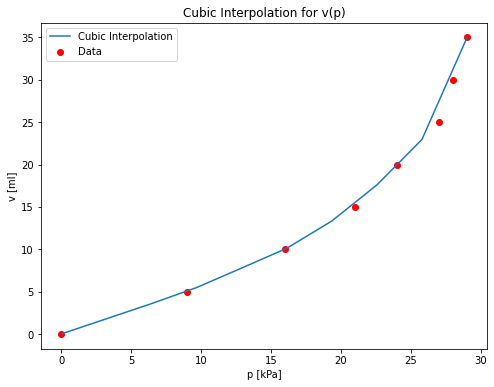

14.0


In [72]:
# Fit PV curve

# Data from Shibo groupmeeting slides pneunet actuator with h = \inf 
v_fit = np.array([0, 5, 10, 15, 20, 25, 30, 35])*1e-6 #[m3] data in mL converted to L
p_fit = np.array([0, 9, 16, 21, 24, 27, 28, 29])*1000 #[pa] data in kpa converted to pa

# Create cubic spline
volume_act = interp1d(p_fit, v_fit, kind='slinear',bounds_error=False, fill_value="extrapolate")

# Plot
p_vals = np.linspace(p_fit[0], p_fit[-1], 10)
v_vals = volume_act(p_vals)

plt.figure(figsize=(8, 6))
plt.plot(p_vals/1000, v_vals*1e6, label='Cubic Interpolation')
plt.scatter(p_fit/1000, v_fit*1e6, color='red', label='Data')
plt.legend()
plt.xlabel('p [kPa]')
plt.ylabel('v [ml]')
plt.title('Cubic Interpolation for v(p)')
plt.show()

p = 20e3  # For example
v = volume_act(p)
print(v*1e6)
volume_act(p_ambient)


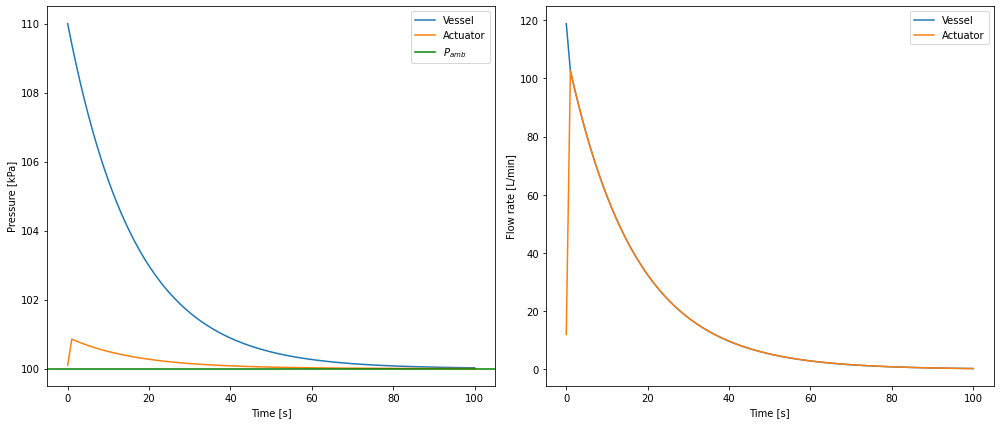

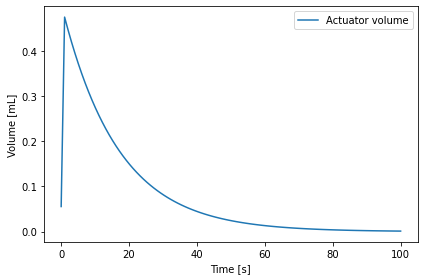

In [87]:
# Parameters
P_tank_0 = 1.1e5  # Initial pressure in first tank, Pa

#P_act_0 must be a fraction higher than P_amb otherwise )_act-P_amb =0 and the solver cannot devide by 0. 
P_act_0 = 1.001e5  # Initial pressure in second tank (ambient pressure), Pa
V_tank = 0.003  # Volume of first tank, m^3
V_act = 0.0003  # Volume of second tank, m^3
P_ambient = 1e5  # Ambient pressure, Pa
R_valve = 5000  # Resistance of first valve, Pa.s/m^3
R_act = 500  # Resistance of second valve, Pa.s/m^3

# System of ODEs
def dPdt(P, t):
    P_tank, P_act = P

    #Volume flow out of tank is pressure difference devided by the resistance of the valve 
    Q_tank = (P_tank - P_act) / R_valve if P_tank > P_act else 0  # Flow rate from tank to actuator
    Q_act = (P_act - P_ambient) / R_act if P_act > P_ambient else 0  # Flow rate from second tank to environment

    # Pressure drop is related to the volume out and the original volume 
    dP_tank_dt = -Q_tank / V_tank  # Change in pressure in tank

    #Volume of actuator is a function of the pressure 
    dP_act_dt = ((Q_tank - Q_act) / volume_act(P_act-P_ambient))*P_act   # Change in pressure in act
    #dP_act_dt = ((Q_tank - Q_act) / V_act)*P_act 
    return [dP_tank_dt, dP_act_dt]

# Time array for simulation
t = np.linspace(0, 100,100 )  # From 0 to 20 seconds, 1000 points in time

# Solve system of ODEs
P_tank, P_act = odeint(dPdt, [P_tank_0, P_act_0], t).T

# Calculate flow rates Q1 and Q2
Q_tank = np.maximum((P_tank - P_act) / R_valve, 0)
Q_act = np.maximum((P_act - P_ambient) / R_act, 0)

# Calculate volume_act over time
V_act = volume_act(P_act-P_ambient)

plt.figure(figsize=(14, 6))

plt.subplot(121)  # The first plot in a 1-row, 2-column configuration
plt.plot(t, P_tank / 1e3, label='Vessel')  # Pressure in first tank, bar
plt.plot(t, P_act / 1e3, label='Actuator')  # Pressure in second tank, bar
plt.axhline(P_ambient/1e3,label='$P_{amb}$',color='green')
plt.xlabel('Time [s]')
#plt.ylim(0, 2)
plt.ylabel('Pressure [kPa]')
plt.legend()

plt.subplot(122)  # The second plot in a 1-row, 2-column configuration
plt.plot(t, Q_tank*60 , label='Vessel')
plt.plot(t, Q_act*60 , label='Actuator')  # Flow rate from second tank, L/s
plt.xlabel('Time [s]')
plt.ylabel('Flow rate [L/min]')
#plt.ylim(0, 10)
plt.legend()

plt.tight_layout()
plt.show()

plt.plot(t, V_act*1E6, label='Actuator volume')  # Volume of actuator, converted to mL
plt.xlabel('Time [s]')
plt.ylabel('Volume [mL]')
#plt.ylim(0,0.5)
plt.legend()

plt.tight_layout()
plt.show()

In [88]:
# Initialize arrays
n_points = len(t)
P_tank = np.zeros(n_points)
P_act = np.zeros(n_points)
Q_tank = np.zeros(n_points)
Q_act = np.zeros(n_points)

# Set initial conditions
P_tank[0] = P_tank_0
P_act[0] = P_act_0

# Time step size
dt = t[1] - t[0]  # Assuming uniform spacing

# Loop over all time points
for i in range(1, n_points):
    # Calculate flow rates at current time step
    Q_tank[i-1] = (P_tank[i-1] - P_act[i-1]) / R_valve if P_tank[i-1] > P_act[i-1] else 0
    Q_act[i-1] = (P_act[i-1] - P_ambient) / R_act if P_act[i-1] > P_ambient else 0

    # Update pressures using Euler method
    P_tank[i] = P_tank[i-1] - (Q_tank[i-1] / V_tank) * dt
    P_act[i] = P_act[i-1] + ((Q_tank[i-1] - Q_act[i-1]) / volume_act(P_act[i-1]-P_ambient)) * P_act[i-1] * dt

# Calculate flow rates at the final time step
Q_tank[-1] = (P_tank[-1] - P_act[-1]) / R_valve if P_tank[-1] > P_act[-1] else 0
Q_act[-1] = (P_act[-1] - P_ambient) / R_act if P_act[-1] > P_ambient else 0


<ipython-input-88-31469dbe7db9>:23: RuntimeWarning: overflow encountered in double_scalars
  P_act[i] = P_act[i-1] + ((Q_tank[i-1] - Q_act[i-1]) / volume_act(P_act[i-1]-P_ambient)) * P_act[i-1] * dt


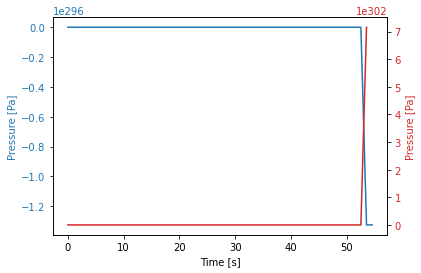

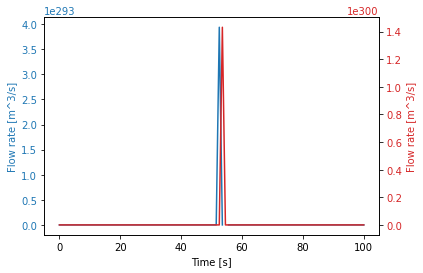

In [89]:
import matplotlib.pyplot as plt

# Create a figure and axes
fig, ax1 = plt.subplots()

# Create a plot of pressure over time for each tank
color = 'tab:blue'
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Pressure [Pa]', color=color)
ax1.plot(t, P_tank, color=color, label='Tank')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second axes for the actuator pressure
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Pressure [Pa]', color=color)
ax2.plot(t, P_act, color=color, label='Actuator')
ax2.tick_params(axis='y', labelcolor=color)

# Create a second figure for the flow rates
fig2, ax3 = plt.subplots()

# Create a plot of flow rate over time for each tank
color = 'tab:blue'
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Flow rate [m^3/s]', color=color)
ax3.plot(t, Q_tank, color=color, label='Q_tank')
ax3.tick_params(axis='y', labelcolor=color)

# Create a second axes for the actuator flow rate
ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel('Flow rate [m^3/s]', color=color)
ax4.plot(t, Q_act, color=color, label='Q_act')
ax4.tick_params(axis='y', labelcolor=color)

# Show the figures
plt.show()
